# Analisi sulle prestazioni

In questo notebook si vuole svolgere un'analisi sulle performance del modulo
implementato. Andremo quindi a confrontare:

- Versione sequenziale e versione parallela.
- Versione sequenziale e DEAP sequenziale.
- Versione parallela e DEAP parallelo (`scoop` e `multiprocessing`).
- Considerazioni finali sul problema specifico del paper per un corretto
  utilizzo della versione parallela ed evitare errori.

## Struttura dei test

I benchmark sono stati effettuati su una macchina con doppio processore AMD
EPYC 7313, ciascuno dei quali a 16 core con frequenza di clock massima a 3.7
GHz. Il problema di riferimento è quello di explainability in cui è stato
eseguito l'algoritmo genetico su un solo punto del dataset e su una sola classe
target. I parametri presi in considerazione sono:

- **Modello**: RandomForestClassifier, SVC e MLPClassifier
- **Numero di individui sintetici**: 1000, 2000, 4000, 8000, 16000
- **Numero di worker**: 1, 2, 4, 8, 16, 32. Le esecuzioni con 1 worker
  corrispondono in realtà alla versione sequenziale dell'algoritmo.

Sono state esplorate tutte le possibili combinazioni di tali parametri e, per
ciascuna di esse sono stati eseguiti 10 test. I risultati di tali test sono
stati poi aggregati prendendo media e deviazione standard dei tempi registrati.

In tutti i test sono stati registrati sia il tempo d'esecuzione totale
dell'algoritmo genetico, sia il tempo d'esecuzione specifico della parte
parallelizzata, sincronizzazione compresa, nel caso dei DEAP la sola
valutazione, nel caso di `ppga` le fasi di crossover, mutazione e valutazione.

## Analisi PPGA

Per prima cosa si vogliono paragonare le prestazioni offerte dalla versione
parallela dell'algoritmo rispetto a alla sua versione sequenziale.

In [1]:
import pandas as pd

ppga_df = pd.read_csv("../datasets/speed.csv")
ppga_df

,classifier,population_size,workers,time,time_std
0,RandomForestClassifier,1000,1,16.299878,0.192166
1,RandomForestClassifier,1000,2,8.289707,0.097571
2,RandomForestClassifier,1000,4,4.415976,0.054106
3,RandomForestClassifier,1000,8,2.492459,0.055834
4,RandomForestClassifier,1000,16,1.841791,0.085909
...,...,...,...,...,...
85,MLPClassifier,16000,2,5.611317,0.031041
86,MLPClassifier,16000,4,3.487661,0.072067
87,MLPClassifier,16000,8,2.582851,0.143285
88,MLPClassifier,16000,16,2.348925,0.144400


Procediamo con il calcolare lo _speed up_ ottenuto per ogni modello e per ogni
numero di individui sintetici.

In [2]:
reference_times = ppga_df[ppga_df['workers'] == 1].set_index(['classifier', 'population_size'])['time']

ppga_df['speed_up'] = ppga_df.apply(lambda row: reference_times.loc[(row['classifier'], row['population_size'])] / row['time'], axis=1)
ppga_df

,classifier,population_size,workers,time,time_std,speed_up
0,RandomForestClassifier,1000,1,16.299878,0.192166,1.000000
1,RandomForestClassifier,1000,2,8.289707,0.097571,1.966279
2,RandomForestClassifier,1000,4,4.415976,0.054106,3.691116
3,RandomForestClassifier,1000,8,2.492459,0.055834,6.539677
4,RandomForestClassifier,1000,16,1.841791,0.085909,8.850015
...,...,...,...,...,...,...
85,MLPClassifier,16000,2,5.611317,0.031041,1.620846
86,MLPClassifier,16000,4,3.487661,0.072067,2.607788
87,MLPClassifier,16000,8,2.582851,0.143285,3.521334
88,MLPClassifier,16000,16,2.348925,0.144400,3.872018


Procediamo con il vedere qualche grafico

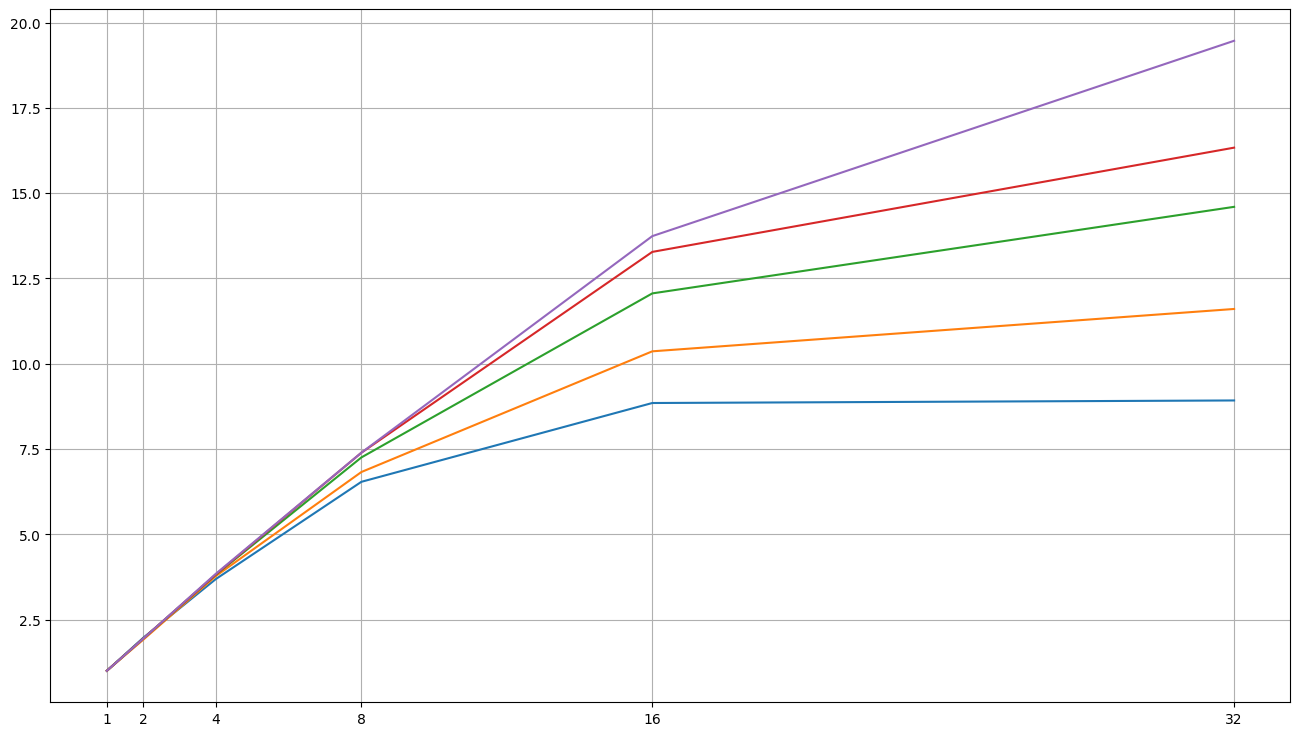

In [3]:
import matplotlib.pyplot as plt

model = "RandomForestClassifier"

workers = ppga_df["workers"].unique()
population_sizes = ppga_df["population_size"].unique()

plt.figure(figsize=(16, 9))
plt.xticks(workers)

for ps in population_sizes:
    mask = (ppga_df["classifier"] == model) & (ppga_df["population_size"] == ps)
    plt.plot(workers, ppga_df[mask]["speed_up"].values)

plt.grid()
plt.show()